24/24 [==============================] - 0s 3ms/step

Cook - PM2.5 Metrics:
Mean Squared Error (MSE): 8.450241752806534
Mean Absolute Error (MAE): 2.3595059298552776
R-squared (R²): 0.7530920850331789
Predicted: 8.70, Actual: 12.90
Predicted: 11.15, Actual: 7.30
Predicted: 9.75, Actual: 9.80
Predicted: 10.31, Actual: 7.60
Predicted: 9.36, Actual: 6.70


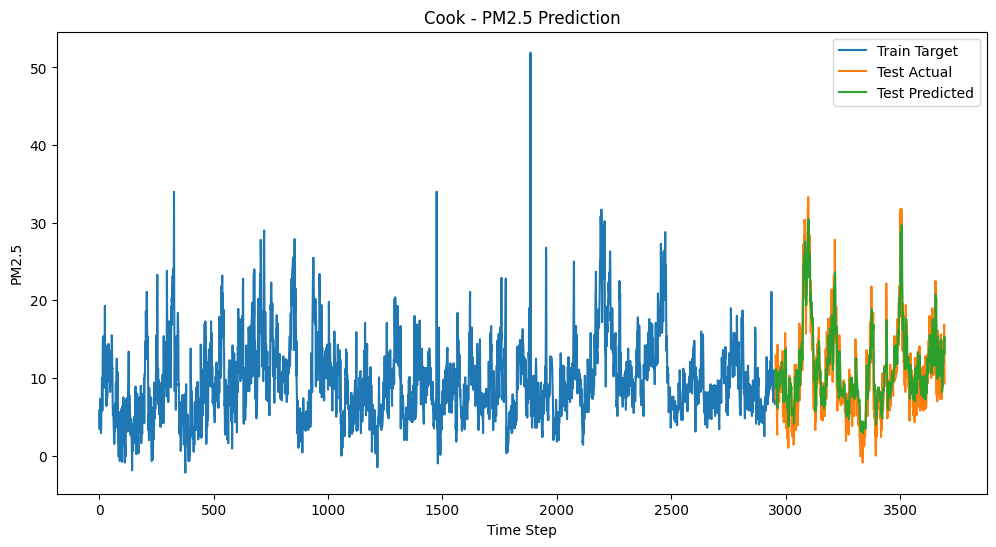

24/24 [==============================] - 0s 3ms/step

Cook - PM10 Metrics:
Mean Squared Error (MSE): 39.299602213110255
Mean Absolute Error (MAE): 4.423490706889614
R-squared (R²): 0.6344209766830912
Predicted: 8.23, Actual: 7.00
Predicted: 7.60, Actual: 6.00
Predicted: 7.34, Actual: 8.00
Predicted: 9.77, Actual: 10.00
Predicted: 13.77, Actual: 6.00


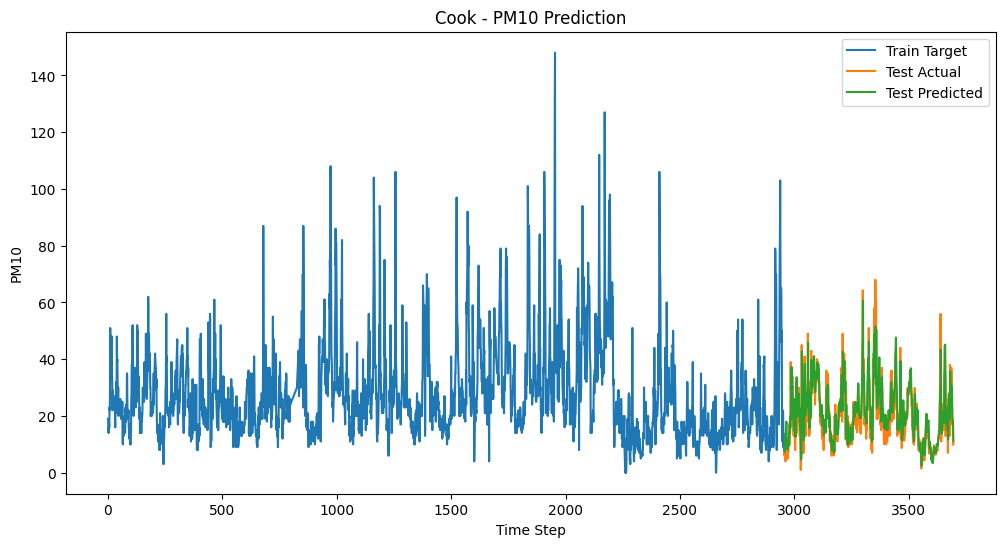

24/24 [==============================] - 0s 3ms/step

Cook - NO2 Metrics:
Mean Squared Error (MSE): 9.750543988793819
Mean Absolute Error (MAE): 2.2398286903881144
R-squared (R²): 0.8098383763651433
Predicted: 10.80, Actual: 10.10
Predicted: 10.77, Actual: 9.70
Predicted: 10.61, Actual: 10.10
Predicted: 10.75, Actual: 10.90
Predicted: 11.33, Actual: 11.20


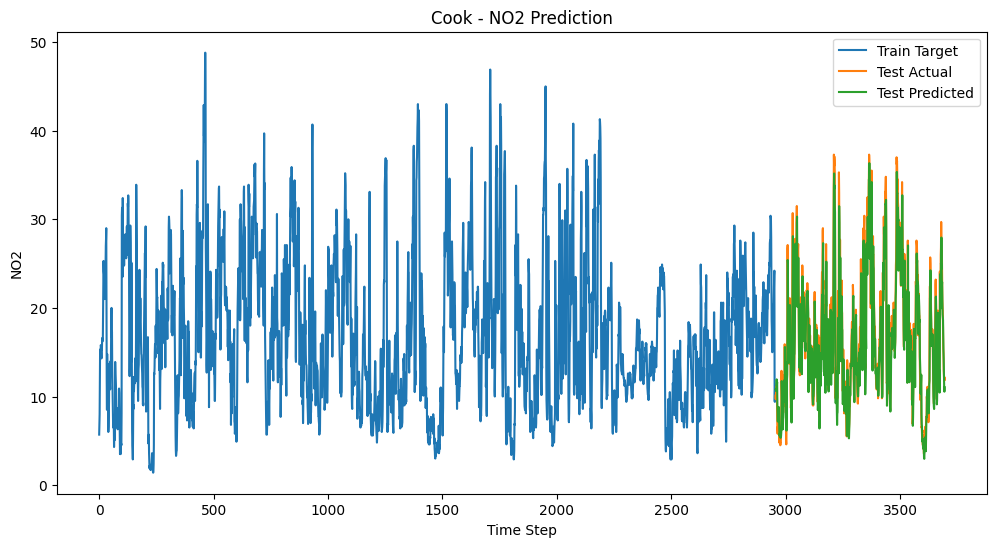

24/24 [==============================] - 0s 3ms/step

Los Angeles - PM2.5 Metrics:
Mean Squared Error (MSE): 14.759071036806354
Mean Absolute Error (MAE): 2.9846135545905033
R-squared (R²): 0.4798077998796181
Predicted: 12.39, Actual: 9.70
Predicted: 10.31, Actual: 8.00
Predicted: 8.86, Actual: 11.90
Predicted: 11.77, Actual: 8.00
Predicted: 9.26, Actual: 6.60


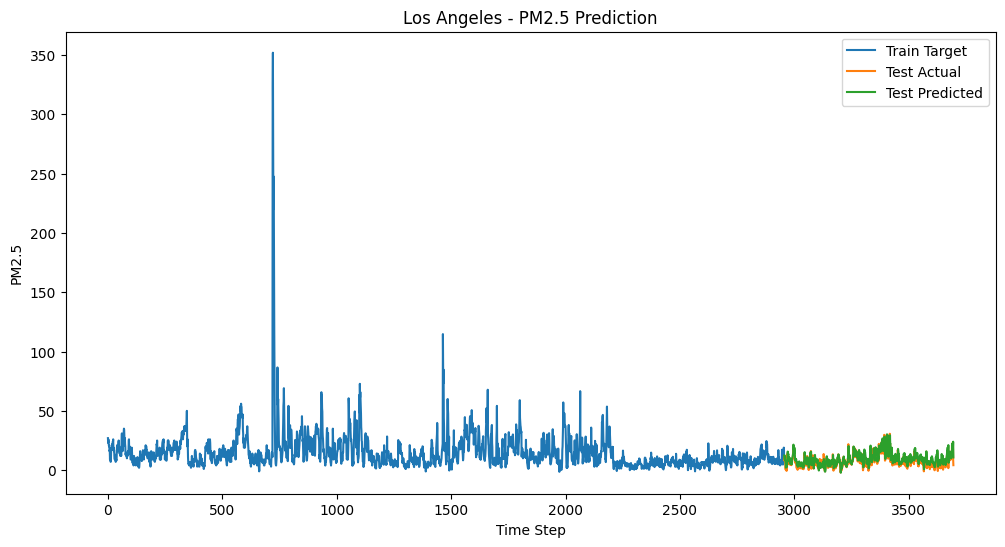

24/24 [==============================] - 0s 3ms/step

Los Angeles - PM10 Metrics:
Mean Squared Error (MSE): 32.387571465206165
Mean Absolute Error (MAE): 3.718975709992574
R-squared (R²): 0.19757154788451403
Predicted: 4.21, Actual: 5.00
Predicted: 5.94, Actual: 7.00
Predicted: 8.14, Actual: 5.00
Predicted: 8.80, Actual: 1.00
Predicted: 7.65, Actual: 2.00


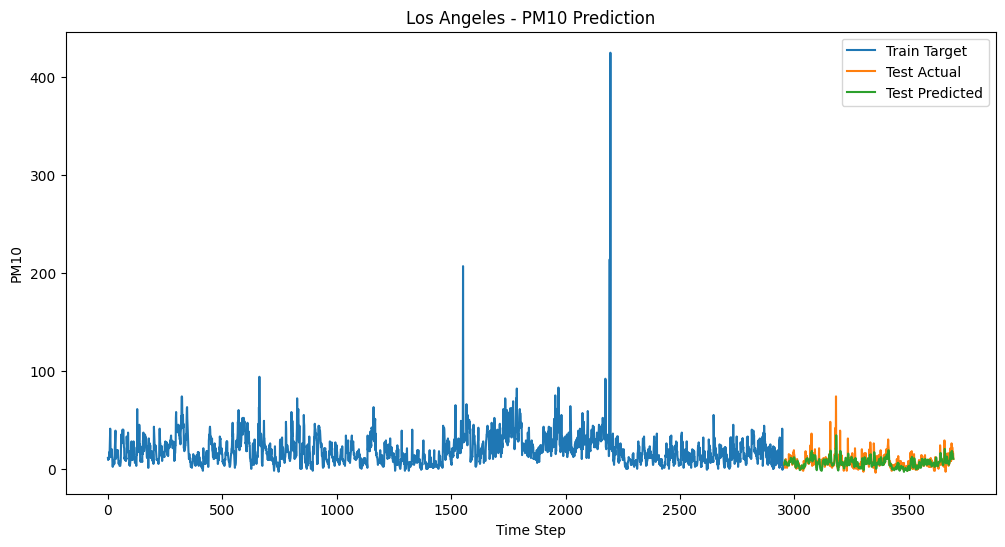

24/24 [==============================] - 0s 3ms/step

Los Angeles - NO2 Metrics:
Mean Squared Error (MSE): 17.11133781639287
Mean Absolute Error (MAE): 2.6450877998879716
R-squared (R²): 0.1479959951315991
Predicted: 6.77, Actual: 2.50
Predicted: 6.36, Actual: 2.20
Predicted: 6.58, Actual: 1.90
Predicted: 5.87, Actual: 3.40
Predicted: 7.17, Actual: 2.30


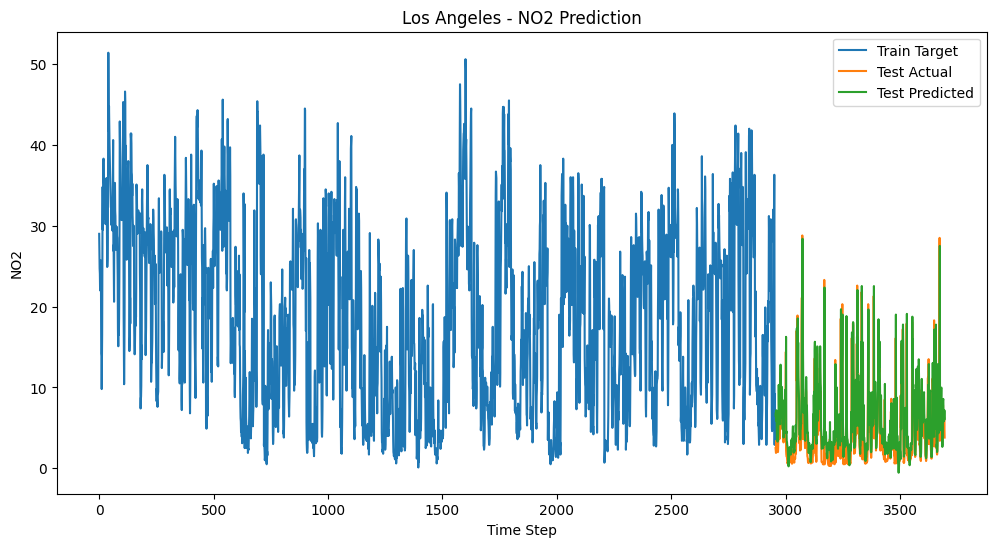

24/24 [==============================] - 0s 3ms/step

New York - PM2.5 Metrics:
Mean Squared Error (MSE): 25.162864962913517
Mean Absolute Error (MAE): 2.6002121884597313
R-squared (R²): 0.48112261566474457
Predicted: 12.12, Actual: 14.90
Predicted: 13.21, Actual: 14.10
Predicted: 13.03, Actual: 17.40
Predicted: 15.16, Actual: 14.30
Predicted: 13.91, Actual: 15.00


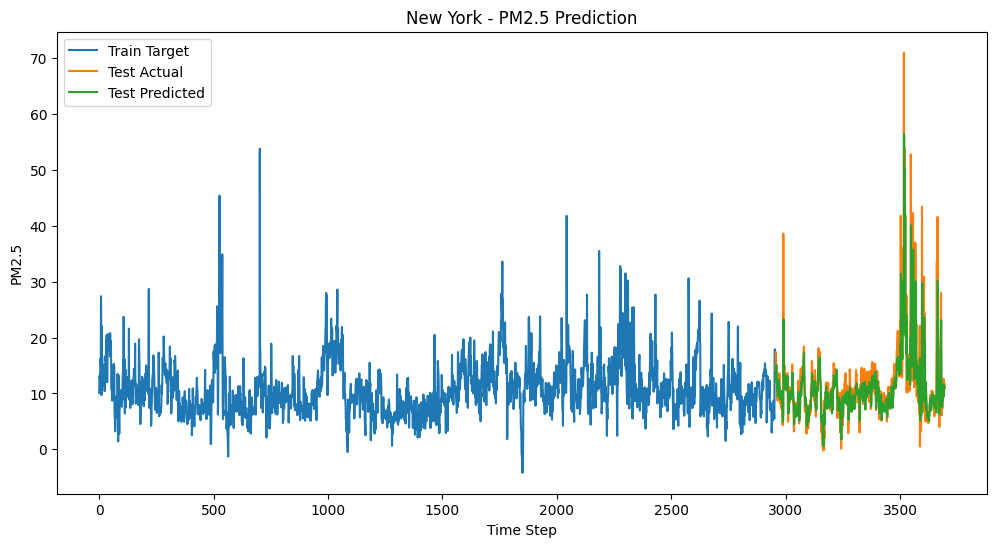

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('updated_air_quality_dataset.csv')

# Function to preprocess data, train LSTM model for a given city and target variable, and plot results
def train_lstm_for_city(data, city_name, target_column):
    # Filter data for the city
    city_data = data[data['County Name'] == city_name]

    # Select relevant columns
    if city_name == 'New York':
        city_data = city_data[['Date', 'Hour', target_column, 'temperature_2m (°C)', 'relative_humidity_2m (%)', 
                                 'precipitation (mm)', 'wind_speed_100m (km/h)', 'Average Traffic Density']]
    else:
        city_data = city_data[['Date', 'Hour', target_column, 'temperature_2m (°C)', 'relative_humidity_2m (%)', 
                                 'precipitation (mm)', 'wind_speed_100m (km/h)']]

    # Convert Date to datetime
    city_data['Date'] = pd.to_datetime(city_data['Date'])

    # Sort by Date and Hour
    city_data = city_data.sort_values(by=['Date', 'Hour'])

    # Handle missing values if any
    city_data = city_data.fillna(method='ffill')

    # Normalize the data
    scaler = MinMaxScaler()
    if city_name == 'New York':
        cols_to_scale = [target_column, 'temperature_2m (°C)', 'relative_humidity_2m (%)', 
                         'precipitation (mm)', 'wind_speed_100m (km/h)', 'Average Traffic Density']
    else:
        cols_to_scale = [target_column, 'temperature_2m (°C)', 'relative_humidity_2m (%)', 
                         'precipitation (mm)', 'wind_speed_100m (km/h)']
    city_data_scaled = scaler.fit_transform(city_data[cols_to_scale])

    # Create sequences for LSTM
    def create_sequences(data, seq_length):
        xs, ys = [], []
        for i in range(len(data) - seq_length):
            x = data[i:(i + seq_length)]
            y = data[i + seq_length, 0]  # Target column is the first one
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)

    seq_length = 24  # 24 hours
    X, y = create_sequences(city_data_scaled, seq_length)

    # Split the data into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=0)

    # Make predictions
    predictions = model.predict(X_test)

    # Inverse transform the predictions to original scale
    dummy_array = np.zeros((len(predictions), city_data_scaled.shape[1]))
    dummy_array[:, 0] = predictions.flatten()  # Fill the target column with predictions
    predictions_original = scaler.inverse_transform(dummy_array)[:, 0]

    # Inverse transform the actual test values
    dummy_array[:, 0] = y_test.flatten()  # Fill the target column with actual values
    y_test_original = scaler.inverse_transform(dummy_array)[:, 0]

    # Calculate MSE, MAE, and R2
    mse = mean_squared_error(y_test_original, predictions_original)
    mae = mean_absolute_error(y_test_original, predictions_original)
    r2 = r2_score(y_test_original, predictions_original)

    # Print the metrics
    print(f'\n{city_name} - {target_column} Metrics:')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R-squared (R²): {r2}')

    # Print some predictions
    for i in range(5):
        print(f'Predicted: {predictions_original[i]:.2f}, Actual: {y_test_original[i]:.2f}')

    # Inverse transform the training target values for plotting
    dummy_array_train = np.zeros((len(y_train), city_data_scaled.shape[1]))
    dummy_array_train[:, 0] = y_train.flatten()
    y_train_original = scaler.inverse_transform(dummy_array_train)[:, 0]

    # Plot the results:
    # X-axis: zaman adımları; ilk kısımda eğitim verileri, son %20'de test (gerçek ve tahmin) verileri
    plt.figure(figsize=(12, 6))
    # Plot training target values
    plt.plot(range(len(y_train_original)), y_train_original, label='Train Target')
    # Plot test actual values
    test_index = range(len(y_train_original), len(y_train_original) + len(y_test_original))
    plt.plot(test_index, y_test_original, label='Test Actual')
    # Plot test predicted values
    plt.plot(test_index, predictions_original, label='Test Predicted')
    plt.xlabel('Time Step')
    plt.ylabel(target_column)
    plt.title(f'{city_name} - {target_column} Prediction')
    plt.legend()
    plt.show()

# List of cities and target columns
cities = ['Cook', 'Los Angeles', 'New York']
target_columns = {
    'Cook': ['PM2.5', 'PM10', 'NO2'],
    'Los Angeles': ['PM2.5', 'PM10', 'NO2'],
    'New York': ['PM2.5']
}

# Train models for each city and target column and plot graphs
for city in cities:
    for target in target_columns[city]:
        train_lstm_for_city(data, city, target)